In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions import Dirichlet, Bernoulli, Uniform
import pandas as pd
from tqdm import tqdm as tm

from src import Simulation as sim
from src import Dir_Reg
from src import Align
from src import visualize_latent_space as vls

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("mps") if torch.backends.mps.is_available() else device

print(device)

cuda


The RGD stuff seems to have 2 stability-ish issues that needs to be addressed:
1. once in a while, it fails to minimize the out-of-simplex loss
2. it is not really affected by the initial guess

In [2]:
class ABC_Monte_Carlo:
    def __init__(self) -> None:
        pass

    
    @staticmethod
    def lat_pos(synth_data, K_groups):
        K = K_groups
        T, n, p = synth_data.shape
        group_membership = torch.arange(K).repeat_interleave(int(n/K)).repeat(T).reshape(T, n, 1)
        time = torch.arange(T).repeat_interleave(n).reshape(T, n, 1)
        new_tensor = torch.cat([time, group_membership, synth_data], dim = 2).reshape(-1, T * n, K + 2).squeeze(dim = 0)
        new_df = pd.DataFrame(new_tensor, columns = ["time", "group", "dim_1", "dim_2", "dim_3"])
        new_df = new_df.astype({"time": int, "group": int, "dim_1": float, "dim_2": float, "dim_3": float})
        return(new_df)
    
    @staticmethod
    class consistency_T2:
        """ keep no_oracle False for now... RGD fucks up the permutation bad, need to minimize wrt permuation in addition """
        def __init__(self, number_of_iterations, nodes_set, beta, alpha_0, seeded = True, constrained = False, oracle_lat_pos = True, oracle_align = False, no_oracle = False):
            self.settings = self.settings(number_of_iterations, nodes_set, beta, alpha_0, seeded, constrained, oracle_lat_pos, oracle_align, no_oracle)
            self.MC_result = self.many_rounds()


        class settings:
            def __init__(self, number_of_iterations, nodes_set, beta, alpha_0, seeded, constrained, oracle_lat_pos, oracle_align, no_oracle):
                self.n_iter = number_of_iterations
                self.n_set = nodes_set
                self.beta = beta
                self.alpha_0 = alpha_0
                self.seeded = seeded
                self.constrained = constrained
                self.OL = oracle_lat_pos
                self.OA = oracle_align
                self.NO = no_oracle

                self.init_model = sim.ABC(time = 2,
                                    nodes = 3,
                                    beta = self.beta,
                                    alpha_0 = self.alpha_0)
                p, q = self.init_model.settings.B.shape
                self.constraint = Dir_Reg.fit.gen_constraint(p , True)
                self.B_size = 4 if self.constrained else q*p

        def one_round(self, nodes, seed = None):

            if seed is not None: 
                torch.manual_seed(seed)
            
            n_type = self.settings.OL + self.settings.OA + self.settings.NO
            q, p = self.settings.init_model.settings.B.shape

            model = self.settings.init_model
            model.update_settings(nodes = nodes)
            constrained = self.settings.constrained

            Z0 = model.synth_data["lat_pos"][0,]
            Z1 = model.synth_data["lat_pos"][1,]
            Y0 = model.synth_data["obs_adj"][0,]
            Y1 = model.synth_data["obs_adj"][1,]

            est_OL= est_OA = est_NO = fish_OL = fish_OA = fish_NO = None
            method_OL= method_OA = method_NO = None
    
            if self.settings.OL:

                if seed is not None: 
                    torch.manual_seed(seed)

                X0_ora_lat_pos = sim.ABC.gen_X(Y0, Z0, model.settings.K)
                est_ora_lat_pos = Dir_Reg.fit(predictor = X0_ora_lat_pos, 
                                            response = Z1, 
                                            constrained = constrained, 
                                            beta_guess = model.settings.beta)
                est_OL = est_ora_lat_pos.est_result["estimate"].reshape(-1)
                fish_OL = est_ora_lat_pos.est_result["fisher_info"].reshape(1, -1)
                method_OL = torch.tensor([[1,0,0]])

            if self.settings.OA:

                if seed is not None: 
                    torch.manual_seed(seed)

                Z0_ora_align = Align.Oracle(Z0, Y0, (p-1)).embed_aligned
                Z1_ora_align = Align.Oracle(Z1, Y1, (p-1)).embed_aligned
                X0_ora_align = sim.ABC.gen_X(Y0, Z0_ora_align, model.settings.K)
                est_ora_align = Dir_Reg.fit(predictor = X0_ora_align, 
                                            response = Z1_ora_align, 
                                            constrained = constrained, 
                                            beta_guess = model.settings.beta)
                est_OA = est_ora_align.est_result["estimate"].reshape(-1)
                fish_OA = est_ora_align.est_result["fisher_info"].reshape(1, -1)
                method_OA = torch.tensor([[0,1,0]])

            if self.settings.NO:
                # if seed is not None: 
                #     torch.manual_seed(seed)

                Z0_no_oracle = Align.No_Oracle(Y0, (p-1)).aligned
                init_guess = Align.Oracle(Z0_no_oracle, Y1, (p-1)).align_mat
                Z1_no_oracle = Align.No_Oracle(Y1, (p-1), init_guess).aligned
                X0_no_oracle = sim.ABC.gen_X(Y0, Z0_no_oracle, model.settings.K)

                est_no_oracle = Dir_Reg.fit(predictor = X0_no_oracle, 
                                            response = Z1_no_oracle, 
                                            constrained = constrained, 
                                            beta_guess = model.settings.beta)
                est_NO = est_no_oracle.est_result["estimate"].reshape(-1)
                fish_NO = est_no_oracle.est_result["fisher_info"].reshape(1, -1)
                method_NO = torch.tensor([[0,0,1]])
            
            est_list = [est_OL, est_OA, est_NO]
            est_to_concat = [item for item in est_list if item is not None]

            method_list = [method_OL, method_OA, method_NO]
            method_to_concat = [item for item in method_list if item is not None]

            est = torch.cat(est_to_concat, dim = 0).unsqueeze(dim = 1)

            method_core = torch.cat(method_to_concat, dim = 0)
            est_constrained = torch.tensor([constrained]).repeat(n_type * p * q).unsqueeze(dim = 1)
            est_nodes = torch.ones(n_type * q * p, 1) * nodes
            est_component = torch.arange(q*p).repeat(n_type).unsqueeze(dim = 1)
            est_method = torch.kron(method_core, torch.ones(q*p, 1))
            real = self.settings.init_model.settings.B.reshape(-1).repeat(n_type).unsqueeze(dim = 1)

            if seed is not None:
                seed_col = torch.ones(n_type * q * p, 1) * seed
                est_full = torch.cat([seed_col, est_nodes, est_constrained, est_method, est_component, est, real], dim = 1)
            else: 
                est_full = torch.cat([est_nodes, est_constrained, est_method, est_component, est, real], dim = 1)

            fish_list = [fish_OL, fish_OA, fish_NO]
            fish_to_concat = [item for item in fish_list if item is not None]
            fish = torch.cat(fish_to_concat, dim = 0)
            fish_nodes = torch.ones(n_type, 1) * nodes
            fish_full = torch.cat([fish_nodes, method_core, fish], dim = 1)

            result_dic = {"est": est_full, "fish": fish_full}

            return(result_dic)
        
        class sim_result:
            def __init__(self, est, fish):
                self.est = est
                self.fish = fish
        
        def many_rounds(self):
            est_result_list = []
            fish_result_list = []
            n_set = self.settings.n_set
            n_iter = self.settings.n_iter

            for i in n_set:
                for j in tm(range(n_iter), desc = str(i)):

                    if self.settings.seeded:
                        temp = self.one_round(i, seed = j)
                    else:
                        temp = self.one_round(i)
                
                    est, fish = temp["est"], temp["fish"]
                    est_result_list.append(est)
                    fish_result_list.append(fish)
            
            est_result = torch.cat(est_result_list, dim = 0)

            if self.settings.seeded is not None:
                est_result = pd.DataFrame(est_result, 
                                          columns = ["seed", "nodes", "constrained", "method_OL", "method_OA", "method_NO", "component", "B_est", "B_real"])
            else: 
                est_result = pd.DataFrame(est_result, 
                                    columns = ["nodes", "constrained", "method_OL", "method_OA", "method_NO", "component", "B_est", "B_real"])
            
            for column in est_result.columns:
                if not column.startswith('B_'):
                    est_result[column] = est_result[column].astype(int)


            fish_result = torch.cat(fish_result_list, dim = 0)

            first_columns = ["nodes", "method_1", "method_2", "method_3"]
            fisher_info_columns = [f"fisher_info_{i+1}" for i in range(fish_result.size(1) - len(first_columns))]
            all_columns = first_columns + fisher_info_columns
            df_full = pd.DataFrame(fish_result.numpy(), columns=all_columns)

            for column in df_full.columns:
                if not column.startswith('fisher_'):
                    df_full[column] = df_full[column].astype(int)

            result = self.sim_result(est_result, df_full)

            return(result)

In [3]:
temp = ABC_Monte_Carlo.consistency_T2(number_of_iterations = 1, 
                                          nodes_set = [1200],
                                          beta = [1,1,-4, 5],
                                          alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]],
                                          seeded = True,
                                          constrained = False,
                                          oracle_lat_pos = True,
                                          oracle_align = False,
                                          no_oracle = False)

1200: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


55


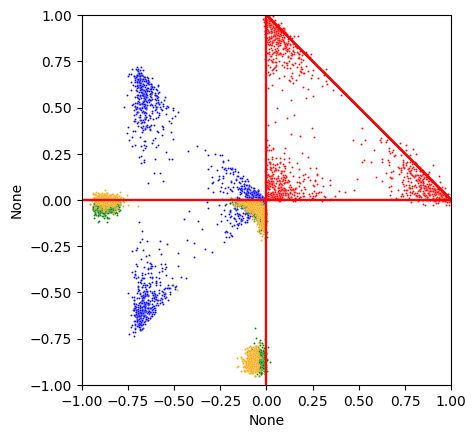

In [14]:
model = sim.ABC(time = 2,
        nodes = 3,
        beta = [1,1,-4, 5],
        alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
p = model.settings.p
torch.manual_seed(54)
model.update_settings(nodes = 1200)
Z0 = model.synth_data["lat_pos"][0,]
Z1 = model.synth_data["lat_pos"][1,]
Y0 = model.synth_data["obs_adj"][0,]
Y1 = model.synth_data["obs_adj"][1,]

i = 54
torch.manual_seed(i)
temp = Align.Oracle.ASE(Y0, (p-1))
vls.lat_vis(temp, -1, "blue")


Z0_no_oracle = Align.No_Oracle(Y0, (p-1)).aligned
init_guess = Align.Oracle(Z0_no_oracle, Y1, (p-1)).align_mat
Z1_no_oracle = Align.No_Oracle(Y1, (p-1), init_guess).aligned
X0_no_oracle = sim.ABC.gen_X(Y0, Z0_no_oracle, model.settings.K)
vls.lat_vis(Z0_no_oracle, -1, "red")
vls.lat_vis(Z1_no_oracle, -1, "green")

temp1 = Align.Oracle.ASE(Y1, (p-1))
vls.lat_vis(temp1 @ init_guess, -1, "orange")
i += 1
print(i)